Project SHCT

Authors: Curumi Klejsi, Querzè Lorenzo  
Spring semester 2025

In [1]:
#import os
#os.chdir("/content/SHCT")
#import sys
#sys.path.append("/content/SHCT")
from pylab import *
import numpy as np
import Fluid_CP as FCP #calculation of  thermodynamic states
from scipy.optimize import minimize, NonlinearConstraint
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# PARAMETERS: 

working_time = 43200 # s, 12 hours in seconds

# Pasta

T_pasta_in = 7 # °C, initial pasta temperature 
T_pasta_fin = 85 # °C, final pasta temperature
m_pasta = 2 # kg, total kg of pasta
m_pasta_basket = 0.5 # kg of pasta per basket
t_break = 300 # s, break time in between batches
t_cook = 420 # s, cooking time for the pasta
R_h2o_pasta = 15 # K/kW, thermal resistance between pasta and water
cp_pasta = 3.5 # kJ/kg K, heat capacity of pasta

# H2O (sink)

T_sink_in = 20 # °C, initial water temperature in the morning
T_min_h2o = 85 # °C, minimum water temperature during operation
T_max_h2o = 93 # °C, maximum water temperature during operation
R_h2o_env = 30 # K/kW, thermal resistance between environment and water
cp_h2o = 4.18 # kJ/kg K, heat capacity of water
rho = 1/FCP.state(['T','p'],[T_max_h2o,1],fluid='water',Eh='CBar')['v'] # kg/m^3, density of water

# Air (source)

T_source = 20 # °C, heat source temperature, constant in cross-flow configuration

# Geometry of the pasta cooker:

h = 0.20 # m
w = 0.27 # m
l = 0.47 # m
V = h*w*l

# Heat duty to heat up the water from 85 to 93°C:

Q_h2o = (V*rho*cp_h2o*(T_max_h2o - T_min_h2o))/t_break
print(Q_h2o)

# Assumptions during modeling: 
# - 0D problem: no temperature gradient inside h2o and pasta
# - constant properties for water and pasta ---> therefore, thermal resistances and cps of pasta and water are constant

# Heat pump design:
# subcritical heat pump process
# techical constraints: superheating, subcooling, optimal COP, pinch points are respected...

2.725114450687218


TASK 1: simulate pasta cooking step

In [5]:
# REQUIRED THERMAL ENERGY INPUT TO COOK THE PASTA

#Q = m_pasta*cp_pasta*(T_pasta_fin - T_pasta_in)
#print('The required thermal energy input to cook pasta is: ', Q, ' kJ')
#Q_dot = Q/t_cook
#print('The required thermal power input to cook pasta is: ', Q_dot, ' kW')

In [7]:
def model(y,t,Q):
    T_h2o, T_pasta = y
    Q_dot_env = (T_h2o - T_source) / R_h2o_env
    Q_dot_pasta = (T_h2o - T_pasta) / R_h2o_pasta
    if Q > 0:        
        dT_h2o_dt = (- Q_dot_pasta + Q) / (V * rho * cp_h2o) # - Q_dot_env - Q_dot_pasta
    else:
        dT_h2o_dt = (- Q_dot_env - Q_dot_pasta) / (V * rho * cp_h2o)
    dT_pasta_dt = (Q_dot_pasta) / (m_pasta * cp_pasta)

    return [dT_h2o_dt, dT_pasta_dt]

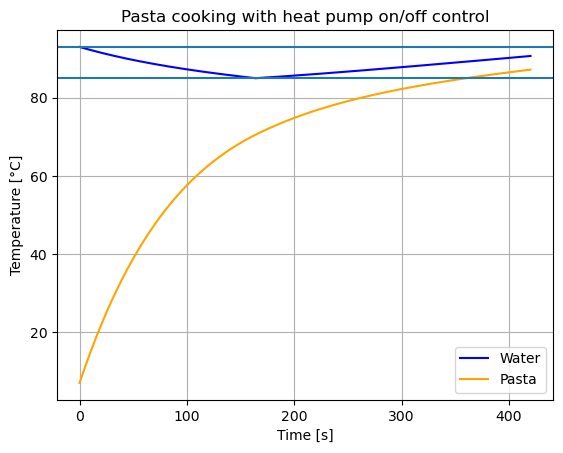

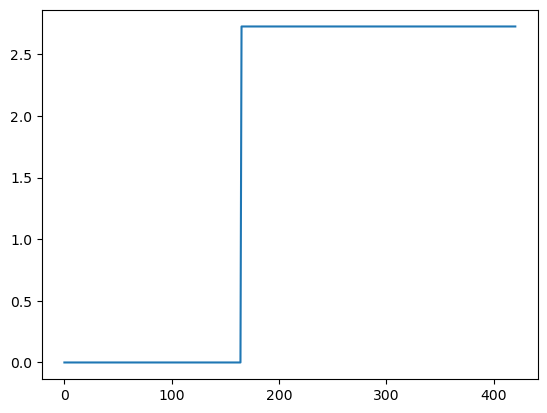

In [9]:
# Simulation setup

dt = 1
t_sim = np.arange(0, t_cook+dt, dt)
state = [T_max_h2o, T_pasta_in]  # [T_h2o, T_pasta]
T_h2o = [state[0]]
T_pasta = [state[1]]
Q_track = [0]
heat_pump = "off"
Q=0

# Time loop

for i in range(1, len(t_sim)):
    
    Tprev = state[0]

    # --- Controller Logic ---
    if Tprev <= T_min_h2o:
        if heat_pump == "off":
            heat_pump = "on"
            Q = Q_h2o        
    
    elif Tprev >= T_max_h2o:
        if heat_pump == "on":
            heat_pump = "off"
            Q = 0       
    
    elif T_min_h2o < Tprev < T_max_h2o:
        if heat_pump == "on":
            Q = Q_h2o
        else:
            Q = 0
    
    # Integrate one step
    state_next = odeint(model, state, [0, dt], args=(Q,))
    state = state_next[-1]  # update current state

    # Store
    T_h2o.append(state[0])
    T_pasta.append(state[1])
    Q_track.append(Q)
plt.plot(t_sim, T_h2o, label='Water', color='blue')
plt.plot(t_sim, T_pasta, label='Pasta', color='orange')
plt.axhline(T_max_h2o)
plt.axhline(T_min_h2o)
plt.xlabel('Time [s]')
plt.ylabel('Temperature [°C]')
plt.legend()
plt.grid(True)
plt.title("Pasta cooking with heat pump on/off control")
plt.show()
#print(T_h2o)
#print(T_pasta)
plt.plot(t_sim, Q_track)

In [11]:
def model2(y,t,Q):
    T_h2o, T_pasta = y
    Q_dot_env = 0
    Q_dot_pasta = 0
    if Q > 0:        
        dT_h2o_dt = (- Q_dot_env - Q_dot_pasta + Q) / (V * rho * cp_h2o)
    else:
        dT_h2o_dt = (- Q_dot_env - Q_dot_pasta) / (V * rho * cp_h2o)
    dT_pasta_dt = (Q_dot_pasta) / (m_pasta * cp_pasta)

    return [dT_h2o_dt, dT_pasta_dt]

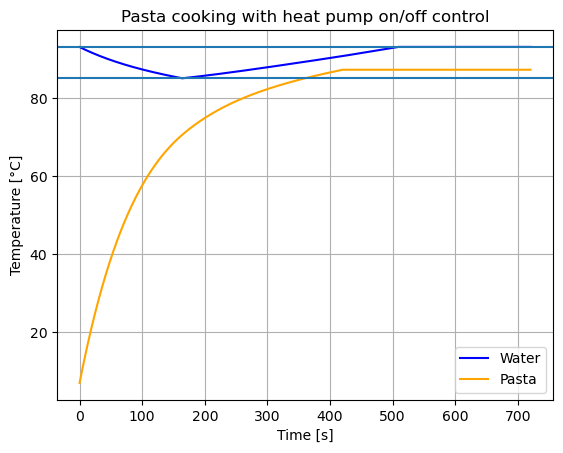

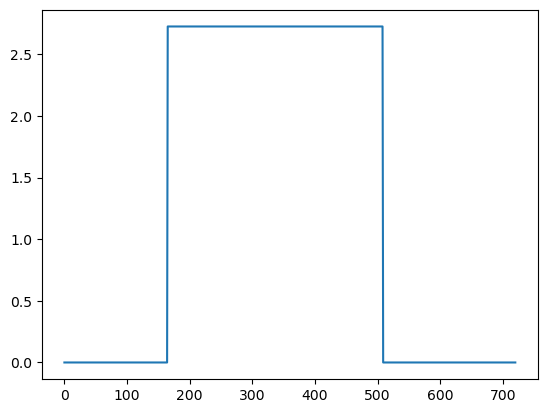

In [13]:
# Simulation setup

dt = 1
t_sim = np.arange(0, t_cook+dt+t_break, dt)
state = [T_max_h2o, T_pasta_in]  # [T_h2o, T_pasta]
T_h2o = [state[0]]
T_pasta = [state[1]]
Q_track = [0]
heat_pump = "off"
Q=0

# Time loop

for i in range(1, len(t_sim)):
    if i > t_cook:
        Tprev = state[0]
        if Tprev <= T_min_h2o:
            if heat_pump == "off":
                heat_pump = "on"
                Q = Q_h2o        
    
        elif Tprev >= T_max_h2o:
            if heat_pump == "on":
                heat_pump = "off"
                Q = 0       
        
        elif T_min_h2o < Tprev < T_max_h2o:
            if heat_pump == "on":
                Q = Q_h2o
            else:
                Q = 0
        # Integrate one step
        state_next = odeint(model2, state, [0, dt], args=(Q,))
        state = state_next[-1]  # update current state
    
        # Store
        T_h2o.append(state[0])
        T_pasta.append(state[1])
        Q_track.append(Q)
        
    else:
        
        Tprev = state[0]

        # --- Controller Logic ---
        if Tprev <= T_min_h2o:
            if heat_pump == "off":
                heat_pump = "on"
                Q = Q_h2o        
    
        elif Tprev >= T_max_h2o:
            if heat_pump == "on":
                heat_pump = "off"
                Q = 0       
        
        elif T_min_h2o < Tprev < T_max_h2o:
            if heat_pump == "on":
                Q = Q_h2o
            else:
                Q = 0
    
        # Integrate one step
        state_next = odeint(model, state, [0, dt], args=(Q,))
        state = state_next[-1]  # update current state
    
        # Store
        T_h2o.append(state[0])
        T_pasta.append(state[1])
        Q_track.append(Q)
        
plt.plot(t_sim, T_h2o, label='Water', color='blue')
plt.plot(t_sim, T_pasta, label='Pasta', color='orange')
plt.axhline(T_max_h2o)
plt.axhline(T_min_h2o)
plt.xlabel('Time [s]')
plt.ylabel('Temperature [°C]')
plt.legend()
plt.grid(True)
plt.title("Pasta cooking with heat pump on/off control")
plt.show()
#print(T_h2o)
#print(T_pasta)
plt.plot(t_sim, Q_track)

[[93.          7.        ]
 [92.92039013  7.81478149]
 [92.84138664  8.62108816]
 [92.76298344  9.41900618]
 [92.68517449 10.20862074]
 [92.60795382 10.99001612]
 [92.53131553 11.7632758 ]
 [92.45525378 12.52848237]
 [92.37976276 13.28571761]
 [92.30483676 14.03506245]
 [92.2304701  14.77659702]
 [92.15665717 15.51040062]
 [92.08339241 16.23655175]
 [92.01067032 16.95512812]
 [91.93848545 17.66620663]
 [91.86683242 18.36986344]
 [91.79570589 19.06617389]
 [91.72510059 19.75521259]
 [91.65501127 20.43705339]
 [91.58543278 21.11176936]
 [91.51635998 21.77943287]
 [91.44778781 22.44011551]
 [91.37971125 23.09388819]
 [91.31212533 23.74082108]
 [91.24502513 24.38098364]
 [91.1784058  25.01444463]
 [91.1122625  25.64127211]
 [91.04659047 26.26153345]
 [90.98138499 26.87529532]
 [90.91664139 27.48262372]
 [90.85235504 28.083584  ]
 [90.78852136 28.67824083]
 [90.72513583 29.26665822]
 [90.66219395 29.84889954]
 [90.59969128 30.42502751]
 [90.53762344 30.99510422]
 [90.47598606 31.55919113]
 

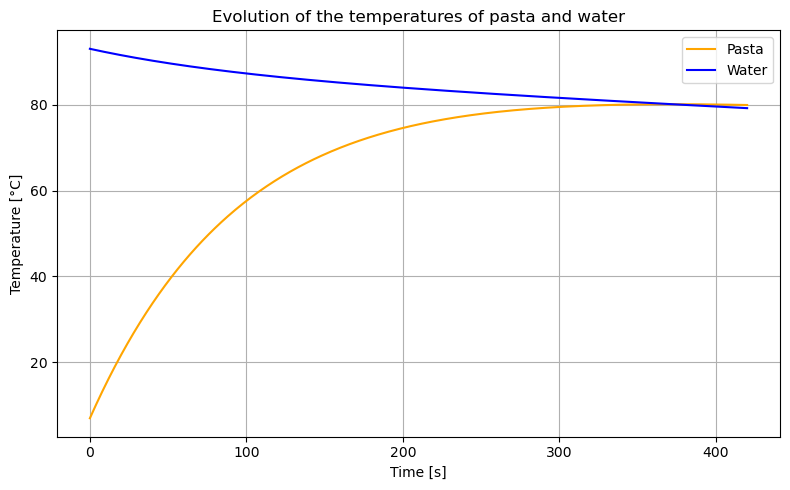

In [16]:
# Setting up the transient simulation

y0 = [T_max_h2o, T_pasta_in]
t = linspace(0,t_cook, t_cook+1)
T_dyn = odeint(model,y0,t)
print(T_dyn)
plt.figure(figsize=(8,5))
plt.plot(t, T_dyn[:, 1], label='Pasta', color='orange')
plt.plot(t, T_dyn[:, 0], label='Water', color='blue')
plt.xlabel('Time [s]')
plt.ylabel('Temperature [°C]')
plt.title('Evolution of the temperatures of pasta and water')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
print(state)

[93.0601084  93.02698974]


In [9]:
def h2o_energy_balance(x):
    T_in, T_fin = x
    rho = 1/FCP.state(['T','p'],[T_in,1],fluid='water',Eh='CBar')['v']
    T_water = np.linspace(T_in, T_fin, t_cook)
    T_pasta = np.linspace(T_pasta_in, T_pasta_fin, t_cook)
    Q = 0
    for t in range(0,t_cook):
        Q = Q + (T_water[t]-T_source)/R_h2o_env + (T_water[t]-T_pasta[t])/R_h2o_pasta
    return np.abs(rho*cp_h2o*V*(T_water[0] - T_water[-1]) - Q)

def h2o_constraint(x):
    T_in, T_fin = x
    return T_in - T_fin

In [13]:
t = linspace(0,t_cook, t_cook+1)
print(t)

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181.
 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 195.
 196. 

In [15]:
NC1 = NonlinearConstraint(h2o_constraint, 0, np.inf)
bounds = [(85,93),(85,93)]
x0 = [91,87]
res = minimize(h2o_energy_balance, x0, method='SLSQP', bounds=bounds, constraints=[NC1])
print(res.x)
print(res.fun)

[93. 85.]
1352.4656648843854


In [ ]:
def h2o_final_temperature(T):
    rho = 1/FCP.state(['T','p'],[T,1],fluid='water',Eh='CBar')['v']
    dt = 1 # timestep
    for i in t:
        